In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from functions import get_params_string
from Paper.figure_scripts import common

In [2]:
Ls = [16, 32, 64, 128]
model = "RBM_alpha1"
n_dim = 1
PBC = True
dtype_ref = jnp.float64
dtypes = [jnp.float32, jnp.float16, jnp.bfloat16]
dtype_labels = ["f32", "f16", "bf16"]
model_labels = ["random", "TFIM", "Heisenberg"]
model_params = [None, {"J": 1, "h": 0.5}, {"J": 1}]

folder = f"{PROJECT_ROOT}Data/LPSE/Average/"

In [3]:
sigmas = np.zeros((len(Ls), len(model_labels), len(dtype_labels)))
re = np.zeros((len(Ls), len(model_labels), len(dtype_labels)))
sigmas = np.zeros((len(Ls), len(model_labels), len(dtype_labels)))
re = np.zeros((len(Ls), len(model_labels), len(dtype_labels)))
sigmas = {"Mean": np.zeros((len(Ls), len(model_labels), len(dtype_labels))), "Error": np.zeros((len(Ls), len(model_labels), len(dtype_labels)))}
re = {"Mean": np.zeros((len(Ls), len(model_labels), len(dtype_labels))), "Error": np.zeros((len(Ls), len(model_labels), len(dtype_labels)))}
re_M_x = {"Mean": np.zeros((len(Ls), len(model_labels), len(dtype_labels))), "Error": np.zeros((len(Ls), len(model_labels), len(dtype_labels)))}
re_M_z = {"Mean": np.zeros((len(Ls), len(model_labels), len(dtype_labels))), "Error": np.zeros((len(Ls), len(model_labels), len(dtype_labels)))}

for l, L in enumerate(Ls):
    for m, model_label in enumerate(model_labels):
        params_str = get_params_string(model_params[m])
        df = pd.read_csv(f"{folder}{model_label}{params_str}_{model}_L{L}_{n_dim}dim.csv")

        sigmas["Mean"][l, m, :] = df["sigma_mean"].to_numpy()
        sigmas["Error"][l, m, :] = df["sigma_error"].to_numpy()
        re["Mean"][l, m, :] = df["re_mean"].to_numpy()
        re["Error"][l, m, :] = df["re_error"].to_numpy()
        re_M_x["Mean"][l, m, :] = df["re_M_x_mean"].to_numpy()
        re_M_x["Error"][l, m, :] = df["re_M_x_error"].to_numpy()
        re_M_z["Mean"][l, m, :] = df["re_M_z_mean"].to_numpy()
        re_M_z["Error"][l, m, :] = df["re_M_z_error"].to_numpy()

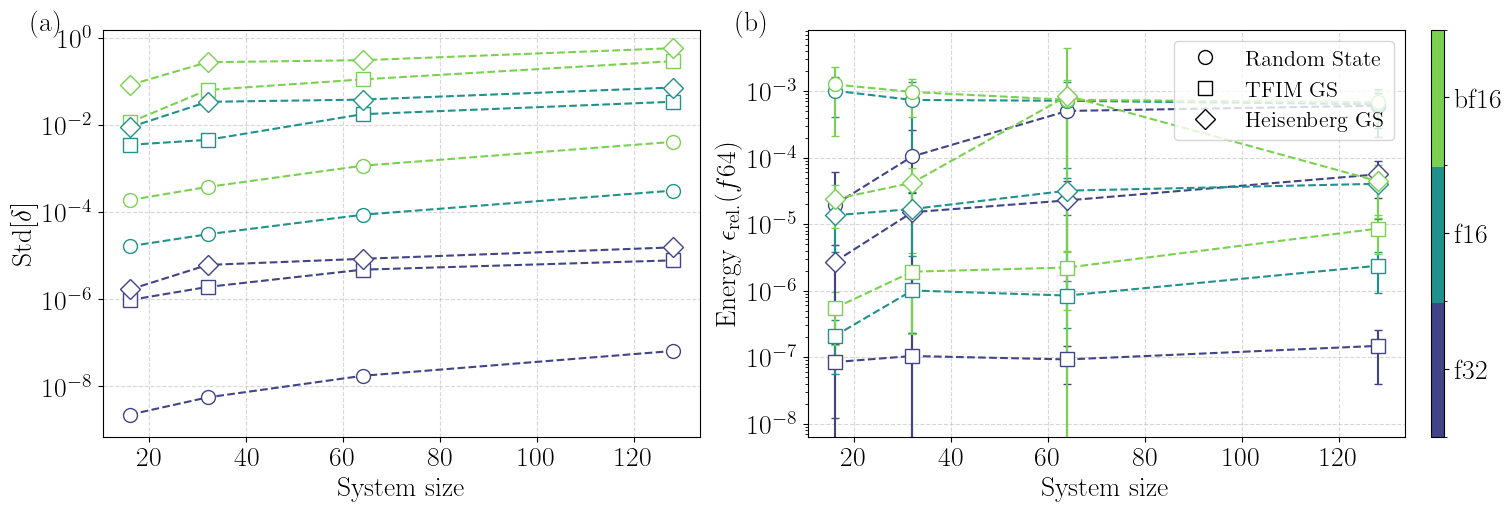

In [4]:
ylabels = [r"$\mathrm{Std}[\delta]$", r"Energy $\epsilon_{\mathrm{rel.}}(f64)$"]
datas = [sigmas["Mean"], re["Mean"]]
errors = [sigmas["Error"], re["Error"]]

model_labels = ["Random State", "TFIM GS", "Heisenberg GS"]
model_markers = ["o", "s", "D"]

n_dtype = len(dtype_labels)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_dtype))
cmap = ListedColormap(colors)

bounds = np.arange(n_dtype + 1)
norm = BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(
    1, 2,
    figsize=(15, 5),
    constrained_layout=True
)

for d, (data, err) in enumerate(zip(datas, errors)):
    ax = axs[d]
    ax.text(-0.12, 1.05, f'({chr(97+d)})', transform=ax.transAxes, fontweight='bold', va='top')

    for model_idx, marker in enumerate(model_markers):
        for dtype_idx in range(n_dtype):
            ax.errorbar(
                Ls,
                data[:, model_idx, dtype_idx],
                yerr=err[:, model_idx, dtype_idx],
                linestyle="--",
                marker=marker,
                color=colors[dtype_idx],
                markerfacecolor="white",
                markeredgecolor=colors[dtype_idx],
                markersize=10,
                capsize=3
            )

    if d == 1:
        legend_elements = [
            Line2D(
                [0], [0],
                linestyle="None",
                marker=model_markers[j],
                color="black",
                label=model_labels[j],
                markerfacecolor="white",
                markeredgecolor="black",
                markersize=10
            )
            for j in range(len(model_labels))
        ]
        ax.legend(handles=legend_elements, loc="upper right")

    ax.set_yscale("log")
    ax.set_ylabel(ylabels[d])
    ax.set_xlabel("System size")
    ax.grid(linestyle="--", alpha=0.5)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(
    sm,
    ax=axs,
    boundaries=bounds,
    ticks=bounds[:-1] + 0.5,
    spacing="uniform",
    aspect=30,
    pad=0.02
)

cbar.ax.set_yticklabels(dtype_labels)
cbar.solids.set_edgecolor("face")
plt.savefig("figures/sigma_different_models.pdf")
plt.show()